## 0.0 - Imports, Paths & Functions

### 0.1 - Imports

In [371]:
from __future__ import print_function
import logging
import os
import nltk
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import wordcloud
from wordcloud import WordCloud
import pandas as pd
import re
import time
import itertools
import copy
import sys
import random

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [372]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### 0.2 - Paths

In [373]:
key = "Y02E_10_20"

data_file = '../Data/{}.csv'.format(key)
dict_file = "{}.dict".format(key)
corpus_file = "{}.mm".format(key)
coords_file = "{}_coords.csv".format(key)
topics_file = "{}_Topics.txt".format(key)

MODELS_DIR = "saved_models/"

### 0.3 - Functions

In [374]:
def progress(percent):
    '''Just a progress bar to be printed to the screen
    '''
    width = 10
    perc = np.floor(percent*width)
    prog = "="*perc + ">"
    if percent != 1:
        print('\r' + 'Progress: [{}] {}%'.format(prog.ljust(width+1), str(percent*100)),end="")
    else:
        print('\r' + 'Progress: [{}] {}%'.format(prog.ljust(width+1), str(percent*100)),end="")
    sys.stdout.flush()

In [375]:
def stream_corp(path):
    '''generator for iterating through lines of the data
    '''
    # regex for sanitizing the abstracts
    html = re.compile(r'\<[^\>]*\>')
    nonan = re.compile(r'[^a-zA-Z ]')

    # read file one line at a time and sanitize
    for line in pd.read_csv(path,sep=',', chunksize=1):
        line = line["appln_abstract"].values[0]
        line = nonan.sub(' ',html.sub('',str(line))).lower().split()
        yield line
        
class MyCorpus(object):
    def __iter__(self):
        # regex for sanitizing the abstracts
        html = re.compile(r'\<[^\>]*\>')
        nonan = re.compile(r'[^a-zA-Z ]')
        
        # read file one line at a time and sanitize
        for line in pd.read_csv(data_file,sep=',', chunksize=1):
            line = line["appln_abstract"].values[0]
            line = nonan.sub(' ',html.sub('',str(line))).lower().split()
            yield self.dictionary.doc2bow(line)

    def make_dictionary(self, stoplist=False, minfreq = 1):
        # create dictionary
        self.dictionary = corpora.Dictionary(line for line in stream_corp(data_file))
        
        if stoplist != False:
            # ids to remove stop words
            stop_ids = [self.dictionary.token2id[stopword] for stopword in stoplist
                        if stopword in self.dictionary.token2id]
        else:
            stop_ids = []
            
        # ids to remove words that appear 'minfreq' or fewer times.
        once_ids = [tokenid for tokenid, docfreq in self.dictionary.dfs.iteritems() if docfreq <= minfreq]
        
        # remove stop words and words that appear only once
        self.dictionary.filter_tokens(stop_ids + once_ids) 
        
        # remove gaps in id sequence after words that were removed
        self.dictionary.compactify() 

## 1.0 - Build and Save Corpus

In [376]:
# paths to relevant folders
#TEXTS_DIR = "/path/to/texts/dir"
MODELS_DIR = "saved_models/"

# stop list from nltk
stoplist = set(nltk.corpus.stopwords.words("english"))

# instantiate corpus object
corpus = MyCorpus() # memory friendly corpus!
#corpus = MyCorpus(TEXTS_DIR, stoplist)

In [377]:
t0 = time.time()
# create dictionary, remove stopwords and words only occurring once
corpus.make_dictionary(stoplist=stoplist,minfreq=5) 
print(time.time() - t0)

t0 = time.time()
# save the dictionary
corpus.dictionary.save(MODELS_DIR + dict_file)
print(time.time() - t0)

t0 = time.time()
# save the corpus
gensim.corpora.MmCorpus.serialize(MODELS_DIR + corpus_file, corpus)
print(time.time() - t0)

85.1846120358
0.0145878791809
116.301250935


## 2.0 - Reduce Dimensions and Save Coords

In [378]:
# load the dictionary
dictionary = gensim.corpora.Dictionary.load(os.path.join(MODELS_DIR, 
                                            dict_file))

# load the corpus
corpus = gensim.corpora.MmCorpus(os.path.join(MODELS_DIR, corpus_file))


tfidf = gensim.models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

print("starting dim reduction for visualization")
t0 = time.time()
# project to 2 dimensions for visualization
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
print(time.time() - t0)

print("writing coordinates to file")
t0 = time.time()
# write out coordinates to file
fcoords = open(os.path.join(MODELS_DIR, coords_file), 'wb')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()
print(time.time() - t0)

starting dim reduction for visualization
17.700920105
writing coordinates to file
10.7827210426


### 4.0 - Find Best Number of Topics

Calculating Kmeans Inertias
8.74701404572


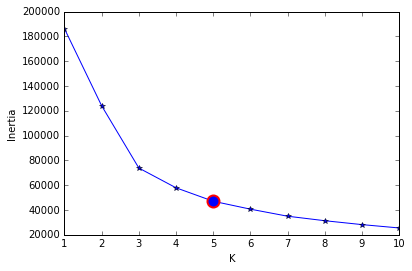

In [379]:
MAX_K = 10

X = np.loadtxt(os.path.join(MODELS_DIR, coords_file), delimiter="\t")
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)

print("Calculating Kmeans Inertias")
t0 = time.time()
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]
print(time.time() - t0)

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

### 5.0 - Vizualize Topic Structure

In [98]:
# Source: viz_topics_scatter.py

MODELS_DIR = "saved_models/"
NUM_TOPICS = 5

print("K-Means Fit")
t0 = time.time()
X = np.loadtxt(os.path.join(MODELS_DIR, coords_file), delimiter="\t")
x = np.array([X[i] for i in random.sample(xrange(len(X)), 1000)])
kmeans = KMeans(NUM_TOPICS).fit(x)
print(time.time() - t0)

y = kmeans.labels_

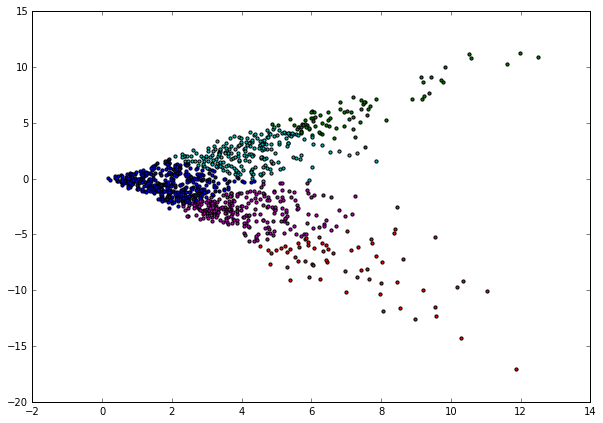

In [99]:
colors = ["b", "g", "r", "m", "c"]
fig = plt.figure(figsize=(10,7))
for i in range(x.shape[0]):
    plt.scatter(x[i][0], x[i][1], c=colors[y[i]], s=10)    
plt.show()

## 6.0 - Perform LDA

### 6.1 - Run LDA Model

In [290]:
NUM_TOPICS = 7

# read in saved dictionary
dictionary = gensim.corpora.Dictionary.load(os.path.join(MODELS_DIR, 
                                            dict_file))
# read in saved corpus
corpus = gensim.corpora.MmCorpus(os.path.join(MODELS_DIR, corpus_file))

# Run LDA model
print("Running LDA Model")
t0 = time.time()
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS)
print(time.time() - t0)

Running LDA Model
501.665647984


### 6.2 - Inspect Topics

In [331]:
# print the topics and their constituent words
print(lda.print_topics(NUM_TOPICS, num_words=25))

# save the topics and their constituent words
f = open(MODELS_DIR+topics_file, 'w')
print(lda.show_topics(num_topics=NUM_TOPICS, num_words=20), end="", file=f)
f.close()

[(0, u'0.038*wind + 0.019*turbine + 0.016*rotor + 0.016*blade + 0.015*shaft + 0.013*generator + 0.010*one + 0.009*blades + 0.008*axis + 0.008*end + 0.008*connected + 0.007*arranged + 0.007*wheel + 0.007*direction + 0.007*first + 0.007*vertical + 0.006*rotation + 0.006*rotating + 0.006*least + 0.006*provided + 0.006*tower + 0.006*second + 0.006*speed + 0.005*comprises + 0.005*two'), (1, u'0.017*material + 0.016*c + 0.013*invention + 0.013*organic + 0.013*group + 0.010*method + 0.009*containing + 0.008*solution + 0.008*least + 0.008*one + 0.008*metal + 0.008*comprising + 0.007*high + 0.007*film + 0.007*compound + 0.006*polymer + 0.006*coating + 0.006*present + 0.006*r + 0.006*dye + 0.006*solar + 0.006*devices + 0.006*temperature + 0.005*relates + 0.005*b'), (2, u'0.048*solar + 0.016*surface + 0.013*cell + 0.012*light + 0.011*module + 0.011*panel + 0.011*plate + 0.009*photovoltaic + 0.009*side + 0.009*one + 0.008*structure + 0.008*plurality + 0.007*frame + 0.007*member + 0.007*support + 0

### 6.3 - Evaluate Results

In [293]:
# get topic probability distribution for each document 
print("Evaluating Documents")
t0 = time.time()
doc_dists = [lda[corpus[i]] for i in range(len(corpus))]
print(time.time() - t0)

# classify each document according to the topic it most corresponded to for 'pred_labels'
tops = [doc_dists[i][np.argmax(doc_dists[i],axis=0)[1]] for i in range(len(doc_dists))]
pred_labels = np.array(tops)[:,0]

Evaluating Documents
358.464091063


In [296]:
# get the subclass of Y02E_10 that each document belongs to as 'true labels'
true_labels = np.array([float(i[9]) for i in pd.read_csv(data_file)["cpc_class_symbol"].values])
target_labels = ["Geothermal energy","Hydro energy","Energy from sea",
                 "Solar thermal energy","PV energy","Thermal-PV hybrids","Wind energy"]

In [297]:
# what classes are there in each set?
print(np.unique(pred_labels))
print(np.unique(true_labels))
print(np.where(true_labels == 0))

[ 0.  1.  2.  3.  4.  5.  6.]
[ 1.  2.  3.  4.  5.  6.  7.]
(array([], dtype=int64),)


In [ ]:
# Need to match topics to a potential cpc subclass. This is essentially
# the stable marriage problem with ties and uneven lists i.e. the SMTI 
# problem which is NP hard... Can either solve greedily, heuristically, 
# or by brute force on a subset.

In [252]:
labels = pd.DataFrame([np.array(true_labels), pred_labels]).T
labels.columns = ["true","pred"]
grouped = labels.groupby("true")

In [253]:
# put into dataframe, groupby and solve incomplete stable marriage problem with ties?
# then analyze confusion matrix
matches = {}
for key, group in grouped.groups.items():
    temp = np.unique(np.array(labels["pred"].values)[group], return_counts=True)
    sort_idx = np.argsort(temp[1])
    matches[key] = [temp[0][sort_idx][::-1], temp[1][sort_idx][::-1]]
matches

# greedy solution
# get unique first choices
# look at ties, give precedent to more confident



# turn into 3 colum, true, pred, freq. by replicating the true column
# then sort by freq.
# highest freq gets his choice.
# remove all other rows with that true label, it no longer needs to compete. 
# remove all rows with that pred label as its preference, we have already matched it.
# highest freq of remaining competetors and remove

# eventually get candidate whos only choices have been taken by bigger bidders... assign it something random?



{1.0: [array([ 3.,  5.,  2.]), array([3, 2, 1])],
 2.0: [array([ 0.,  3.,  6.,  7.,  1.,  2.,  5.]),
  array([91, 39, 27,  9,  9,  6,  1])],
 3.0: [array([ 0.,  7.,  3.]), array([17,  3,  3])],
 4.0: [array([ 5.,  3.,  1.,  4.,  2.,  0.,  6.,  7.]),
  array([50, 46, 31, 24, 18,  9,  6,  2])],
 5.0: [array([ 2.,  4.,  6.,  1.,  0.,  3.,  5.]),
  array([365,  51,  45,  39,   6,   5,   1])],
 7.0: [array([ 7.,  0.,  1.,  6.,  3.]), array([50, 25,  8,  7,  1])]}

In [327]:
# get all possible mappings of label predictions to true patent classes
perms = list(itertools.permutations(np.arange(1,8), 7))

# get indexes of each class of prediction, so we may swap labels
idx_list = [np.where(pred_labels == i) for i in range(7)]

# temporary array of predictions to alter with label map permutations
temp = copy.deepcopy(pred_labels)

In [353]:
# brute force testing of each permutation
accuracies = []
N = float(len(perms))
for j, perm in enumerate(perms):
    progress(float(j)/N)
    for i, idx in enumerate(idx_list):
        temp[idx] = perm[i]
    accuracies.append(classification_report(true_labels, temp).split()[-4])

Progress: [=========> ] 99.9801587302%

In [354]:
def plot_confusion_matrix(cm, tnames, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tnames))
    plt.xticks(tick_marks, tnames, rotation=45)
    plt.yticks(tick_marks, tnames)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(7, 1, 3, 4, 5, 6, 2) 0.77
                      precision    recall  f1-score   support

   Geothermal energy       0.09      0.69      0.16      3706
        Hydro energy       0.05      0.06      0.06     20739
     Energy from sea       0.17      0.56      0.26      5726
Solar thermal energy       0.06      0.03      0.04     47091
           PV energy       0.98      0.46      0.62    110034
  Thermal-PV hybrids       0.00      0.29      0.00        48
         Wind energy       0.66      0.66      0.66     44615

         avg / total       0.62      0.38      0.44    231959

Normalized confusion matrix


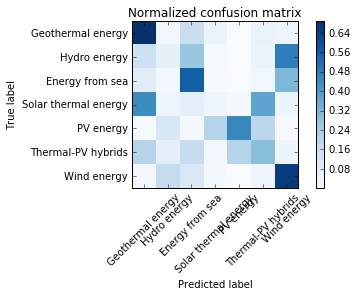

In [369]:
# find best map
best = np.argmax(accuracies)
print(perms[best], accuracies[best])
manual_best = [7, 4, 6, 1, 5, 2, 3]
# evaluate LDA performance under best map
for i, idx in enumerate(idx_list):
        #temp[idx] = perms[best][i]
        temp[idx] = manual_best[i]
print(classification_report(true_labels, temp, target_names=target_labels))

cm = confusion_matrix(true_labels, temp)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized,target_labels, title='Normalized confusion matrix')
plt.show()

### 6.4 - Visualize Results

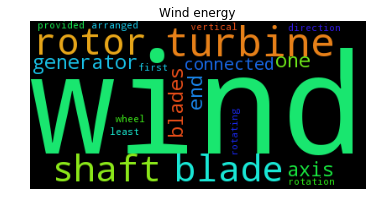

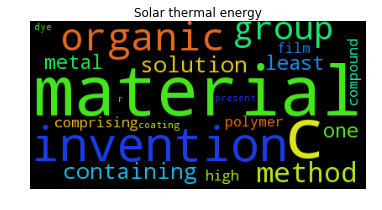

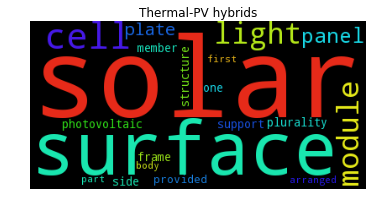

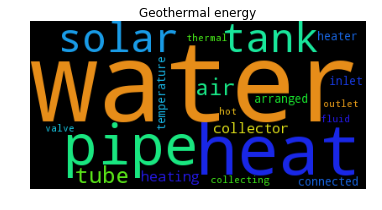

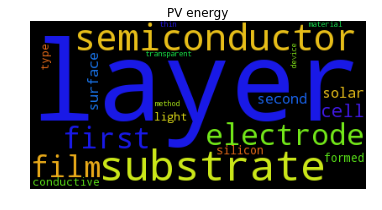

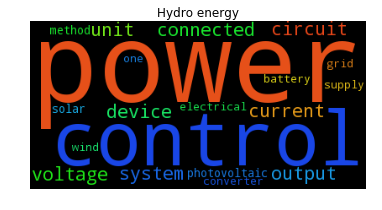

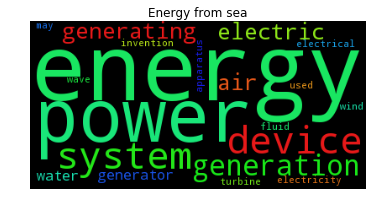

In [370]:
#def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


final_topics = open(os.path.join(MODELS_DIR, topics_file), 'rb')

lines = final_topics.readlines()[0].strip("[()").strip("]\n").split("(")
lines = [i.strip("),").split(", u'")[1] for i in lines]
curr_topic = 0
classes = np.array(target_labels)[np.array(list(manual_best)) - 1]
for j, line in enumerate(lines):
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1].strip("'), ") for x in line.split(" + ")]

    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    
    wc = WordCloud(max_words=100)
    elements = wc.fit_words(freqs)
    # wc.draw(elements, "gs_topic_%d.png" % (curr_topic),
    #               width=120, height=120)
    # store default colored image
    default_colors = wc.to_array()
    #plt.title("Custom colors")
    #plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
    #wc.to_file("a_new_hope.png")
    #plt.axis("off")
    
    plt.figure()
    plt.title(classes[j])
    plt.imshow(default_colors)
    plt.axis("off")
    plt.show()
    
    curr_topic += 1
final_topics.close()

In [347]:
#Y02E 10/10    Geothermal energy

#Y02E 10/20    Hydro energy

#Y02E 10/30    Energy from sea (tidal stream Y02E 10/28 )(not used; see subgroups)

#Y02E 10/40    Solar thermal energy

#Y02E 10/50    Photovoltaic [PV] energy

#Y02E 10/60    Thermal-PV hybrids

#Y02E 10/70    Wind energy

#make confusion matrix of true labels...